Sleep analysis

This script will take any zip file exported from Fitbit and will visualize data through seaborn and matplotlib.
Do not touch the code except where specified. Credit to Logan Hennessey for inspiration for script.

These are our imports: the libraries we use in our analysis. os allows us to work with files/paths, zipfile unzips folders, shutil copies files, pandas allows us to work with dataframes, seaborn allows for visualization.

In [3]:
import os
import zipfile
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
%matplotlib inline
register_matplotlib_converters()

Unzip the zipped folder

In [6]:
with zipfile.ZipFile('20Jun26 - Selena_Fitbit_Data_Export.zip', 'r') as zip_ref:
    zip_ref.extractall()

Looks within user-site-export for json data, shows unique filenames (types)

In [7]:
myPath = "./SelenaDirven/user-site-export/"
filenames = os.listdir(myPath)
print(f"Parsing {len(filenames)} files for unique types.")
unique_filenames = set()
for f in filenames:
    unique_filenames.add(f.split("-")[0])
print(f"Found {len(unique_filenames)} unique types.")
for name in sorted(unique_filenames):
    print(name)

Parsing 1061 files for unique types.
Found 16 unique types.
badge.json
calories
demographic_vo2_max
distance
exercise
heart_rate
height
lightly_active_minutes
moderately_active_minutes
resting_heart_rate
sedentary_minutes
sleep
steps
time_in_heart_rate_zones
very_active_minutes
weight


Creates a folder and copies data from user-site-export to it

In [8]:
myName = input('Enter name:')
if os.path.exists(myName):
    print('This exists!')
else:
    shutil.copytree(myPath, myName) 

Enter name: Selena


Adds sleep data to dataframe

In [9]:
jsondf = []
print('Working on:')
count=0
for file in os.listdir(myName):
    if file.startswith('sleep'):
        print(file)
        jsondf.append(pd.read_json(myName+"/"+file))
    count += 1
df = pd.concat(jsondf)

Working on:
sleep-2018-12-24.json
sleep-2019-01-23.json
sleep-2019-02-22.json
sleep-2019-03-24.json
sleep-2019-04-23.json
sleep-2019-05-23.json
sleep-2019-06-22.json
sleep-2019-07-22.json
sleep-2019-08-21.json
sleep-2019-09-20.json
sleep-2019-10-20.json
sleep-2019-11-19.json
sleep-2019-12-19.json
sleep-2020-01-18.json
sleep-2020-02-17.json
sleep-2020-03-18.json
sleep-2020-04-17.json
sleep-2020-05-17.json
sleep-2020-06-16.json


Saves the dataframe to a csv file for easy access.

In [10]:
with open(myName+".csv", "w") as df_csv:
    df.to_pickle(name+".csv") 

You don't need to run this next line if you are starting from line one. This is to open your saved dataset (if you ran the script before) for faster access.

In [11]:
df = pd.read_pickle(name+".csv")


First 5 rows of your dataframe

In [12]:
df.head(5)

,logId,dateOfSleep,startTime,endTime,duration,minutesToFallAsleep,minutesAsleep,minutesAwake,minutesAfterWakeup,timeInBed,efficiency,type,infoCode,levels,mainSleep
0,20940698239,2019-01-23,2019-01-22T22:39:30.000,2019-01-23T07:13:30.000,30840000,0,449,65,0,514,97,stages,0,"{'summary': {'deep': {'count': 4, 'minutes': 9...",True
1,20929750385,2019-01-22,2019-01-21T21:52:30.000,2019-01-22T07:26:30.000,34440000,0,507,67,0,574,98,stages,0,"{'summary': {'deep': {'count': 6, 'minutes': 1...",True
2,20916176715,2019-01-21,2019-01-20T22:37:30.000,2019-01-21T08:05:30.000,34080000,0,492,76,0,568,91,stages,0,"{'summary': {'deep': {'count': 2, 'minutes': 9...",True
3,20902697196,2019-01-20,2019-01-20T00:39:30.000,2019-01-20T07:40:00.000,25200000,0,344,76,0,420,96,stages,0,"{'summary': {'deep': {'count': 4, 'minutes': 7...",True
4,20902697194,2019-01-19,2019-01-19T20:18:00.000,2019-01-19T21:42:00.000,5040000,0,77,7,0,84,92,classic,2,"{'summary': {'restless': {'count': 6, 'minutes...",False


Example of your sleep data format

In [13]:
df.iloc[0].levels['summary']

{'deep': {'count': 4, 'minutes': 91, 'thirtyDayAvgMinutes': 87},
 'wake': {'count': 30, 'minutes': 65, 'thirtyDayAvgMinutes': 74},
 'light': {'count': 29, 'minutes': 233, 'thirtyDayAvgMinutes': 279},
 'rem': {'count': 9, 'minutes': 125, 'thirtyDayAvgMinutes': 78}}

Function to extract minutes from levels

In [14]:
def get_minutes(levels, sleep_phase):
    if not levels.get('summary'):
        return None
    if not levels.get('summary').get(sleep_phase):
        return None
    if not levels.get('summary').get(sleep_phase).get('minutes'):
        return None
    return levels['summary'][sleep_phase]['minutes']

Apply function to each of the 4 categories

In [15]:
df['deepSleep'] = df.levels.apply(get_minutes, args=('deep',))
df['wakeMins'] = df.levels.apply(get_minutes, args=('wake',))
df['lightSleep'] = df.levels.apply(get_minutes, args=('light',))
df['remSleep'] = df.levels.apply(get_minutes, args=('rem',))

Turn index to datetime object

In [16]:
df.dateOfSleep = pd.to_datetime(df.dateOfSleep)
df.set_index("dateOfSleep", drop=True, inplace=True)
df.sort_index(inplace=True)

Drop unwanted variables/data

In [17]:
df.drop(columns=([
    "logId", 
    "startTime", 
    "endTime", 
    "duration", 
    "minutesToFallAsleep", 
    "minutesAwake", 
    "minutesAfterWakeup", 
    "efficiency",
    "type",
    "infoCode",
    "levels",
    "mainSleep"
]), inplace=True)

Get rid of na spaces

In [18]:
df.dropna(inplace=True)

In [19]:
df.head()

,minutesAsleep,timeInBed,deepSleep,wakeMins,lightSleep,remSleep
dateOfSleep,,,,,,
2018-12-26,467,519,115.0,52.0,283.0,69.0
2018-12-27,462,519,66.0,57.0,300.0,96.0
2018-12-28,495,562,98.0,67.0,299.0,98.0
2018-12-29,444,523,101.0,79.0,285.0,58.0
2018-12-30,463,543,118.0,80.0,278.0,67.0


Plot everything!

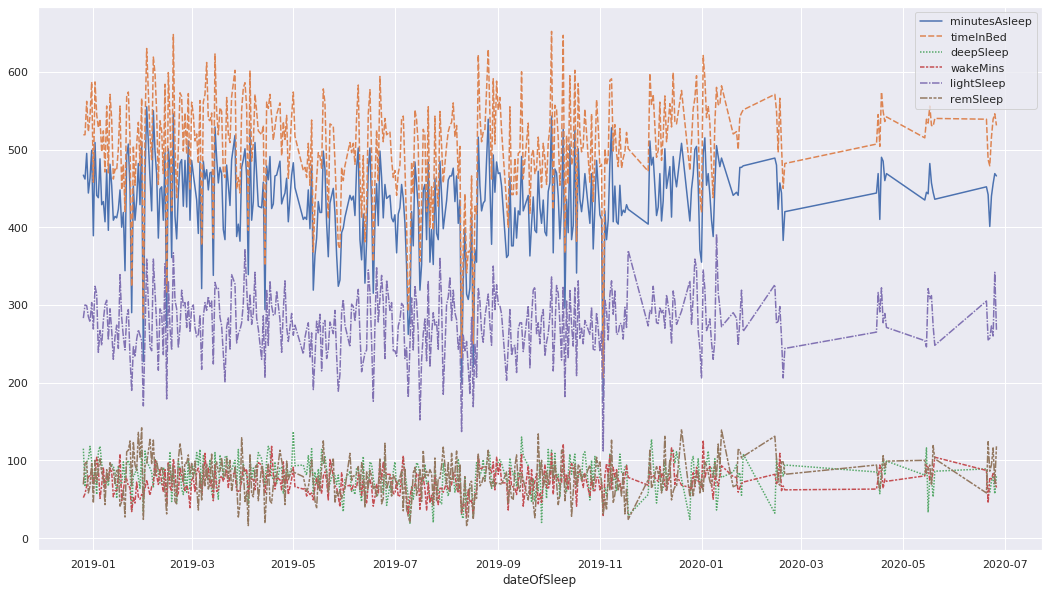

In [20]:
sns.set()
fig, ax = plt.subplots(figsize=(18,10))
sns.lineplot(ax=ax, data=df)

Show data from date:

Choose a date, format YYYY-MM-DD 2020-01-01


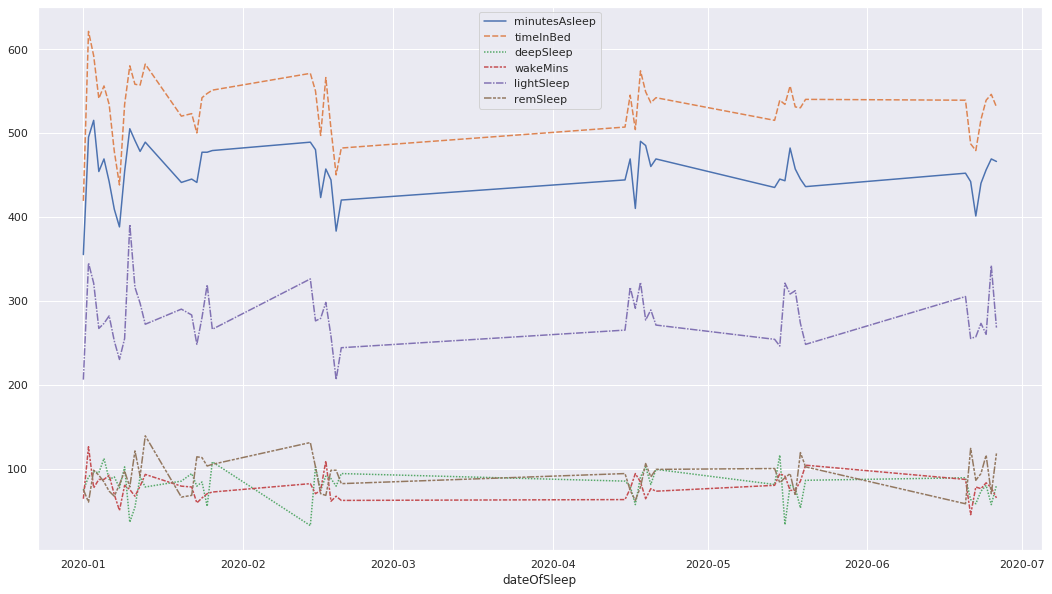

In [21]:
date = input('Choose a date, format YYYY-MM-DD')
fig, ax = plt.subplots(figsize=(18,10))
sns.lineplot(ax=ax, data=df[df.index >= date]) 
plt.savefig(date+'.png')

Divide minutes by 60 (to get hours)

In [22]:
df = df.div(60)

Matplotlib version of graphing

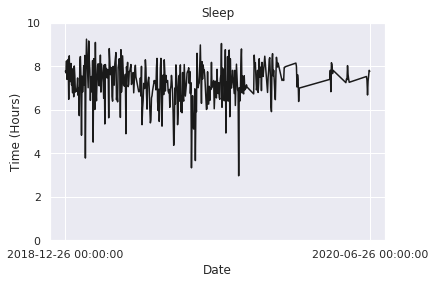

In [23]:
plt.ylim(0,10)
plt.xlabel('Date')
plt.ylabel('Time (Hours)')
plt.title('Sleep')
t = [df.index.min(), df.index.max()]
plt.xticks(t,t)
plt.plot(df['minutesAsleep'], color='k')
plt.savefig("sleep.png")

Exact same code as line 37, but in minutes!

Choose a date, format YYYY-MM-DD 2020-01-01


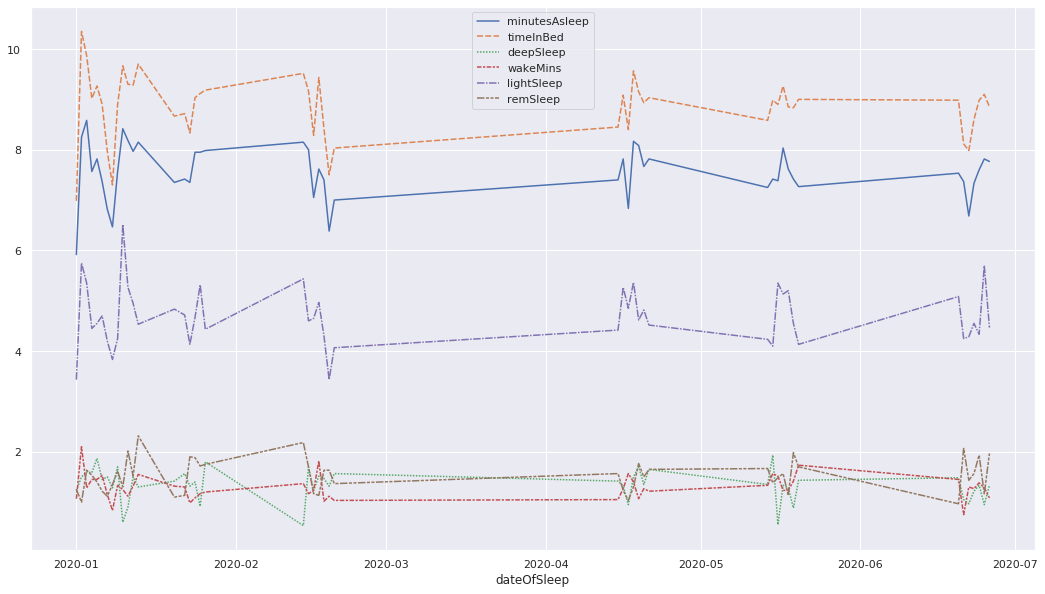

In [24]:
date = input('Choose a date, format YYYY-MM-DD')
fig, ax = plt.subplots(figsize=(18,10))
sns.lineplot(ax=ax, data=df[df.index >= date]) 
plt.savefig(date+'-min.png')